In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
base_dir = '/kaggle/input/satellite-image-classification/data'

In [3]:
categories = ['cloudy', 'desert', 'green_area','water']
image_data = []
labels = []


In [4]:
for category in categories:
    folder_path = os.path.join(base_dir, category)
    class_index = categories.index(category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            # Read and resize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            image_data.append(img_array)
            labels.append(class_index)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

In [5]:
# Convert to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

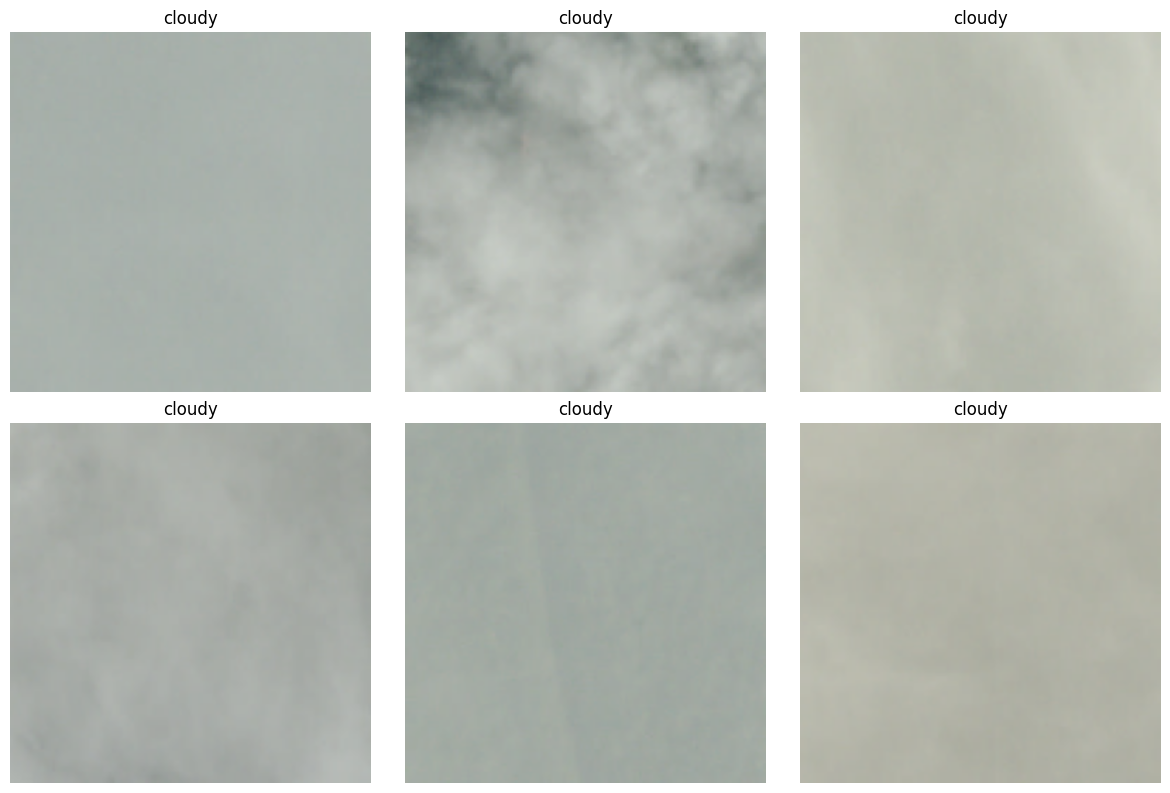

In [6]:
def plot_sample_images(image_data, labels, categories):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_data[i].astype('uint8'))
        plt.title(categories[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(image_data, labels, categories)

In [7]:
# Normalize the image data
image_data = image_data / 255.0

In [8]:
# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(categories))

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

In [10]:
# Feature Engineering: Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:

from tensorflow.keras.layers import Input

# Model Building: CNN with Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),  # Add the Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])



In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Create a data generator for the validation set (without augmentation)
validation_data_generator = ImageDataGenerator(rescale=1./255)

# Prepare validation data generator
validation_generator = validation_data_generator.flow(X_test, y_test, batch_size=batch_size)

# Train the model using the validation generator
history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 568ms/step - accuracy: 0.8432 - loss: 0.3986 - val_accuracy: 0.2509 - val_loss: 3.3487 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - accuracy: 0.9062 - loss: 0.3377 - val_accuracy: 0.4286 - val_loss: 3.0457 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 580ms/step - accuracy: 0.8594 - loss: 0.3662 - val_accuracy: 0.2527 - val_loss: 2.7168 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - accuracy: 0.6250 - loss: 0.5979 - val_accuracy: 0.1429 - val_loss: 2.9149 - learning_rate: 0.0010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 573ms/step - accuracy: 0.8544 - loss: 0.3630 - val_accuracy: 0.2509 - val_loss: 4.5468 - learning_rate: 0.0010


In [21]:
# Evaluation: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

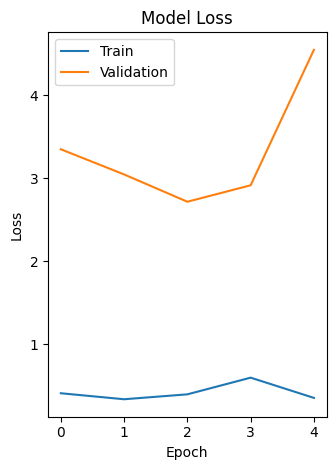

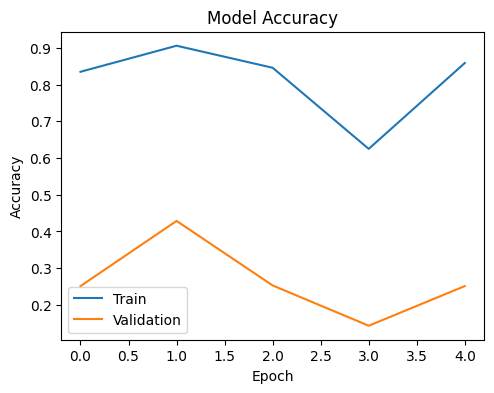

In [22]:

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [23]:
# Model Evaluation on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step


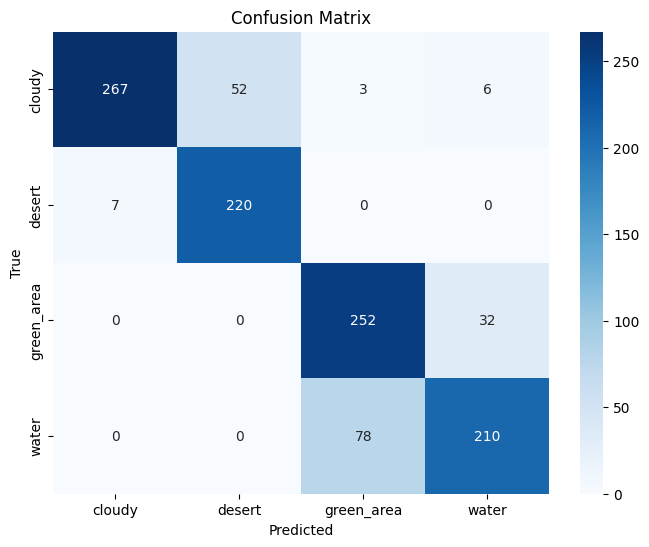

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

Classification Report:

              precision    recall  f1-score   support

      cloudy       0.97      0.81      0.89       328
      desert       0.81      0.97      0.88       227
  green_area       0.76      0.89      0.82       284
       water       0.85      0.73      0.78       288

    accuracy                           0.84      1127
   macro avg       0.85      0.85      0.84      1127
weighted avg       0.85      0.84      0.84      1127



In [28]:
# Plot training history: accuracy and loss over epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

In [31]:
# Plot training history: accuracy and loss over epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

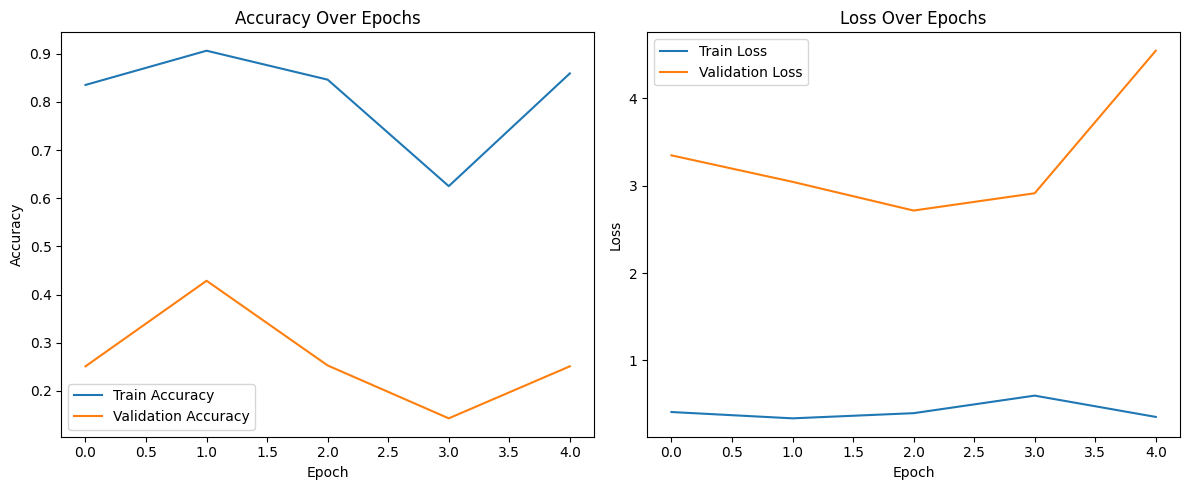

In [32]:
plot_training_history(history)

# ROC Curve and AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

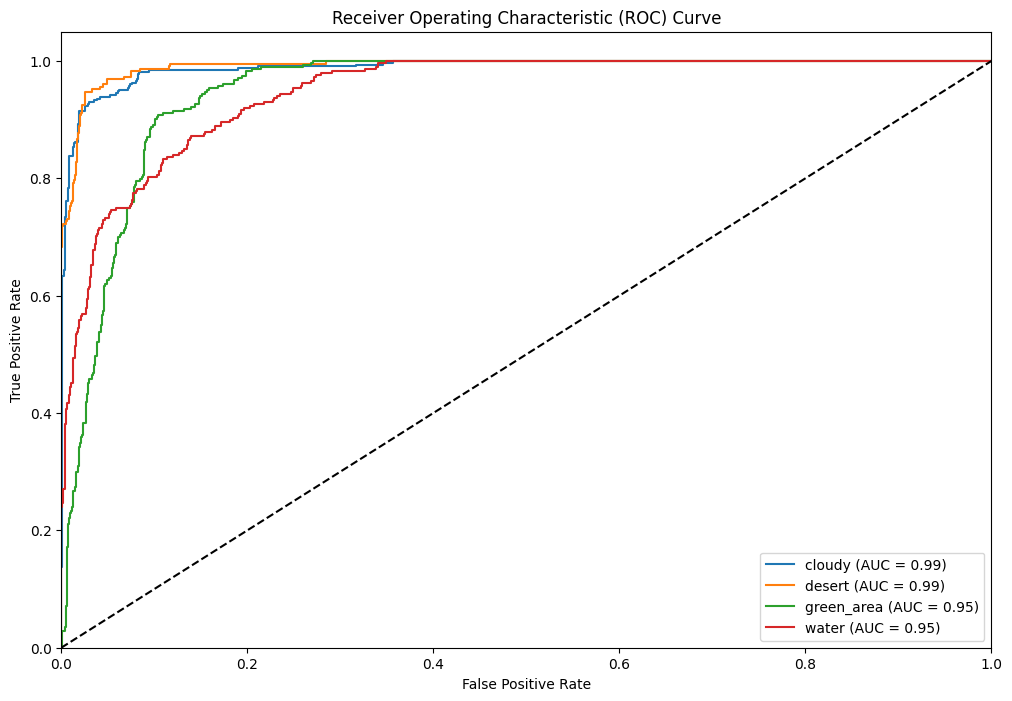

In [33]:
# Binarize the labels for ROC curve plotting
y_test_binarized = label_binarize(y_true_classes, classes=np.arange(len(categories)))

plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [34]:
# Additional metrics: Precision, Recall, F1-score for each class
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Display precision, recall, and F1-score for each class
metrics_df = pd.DataFrame({
    'Class': categories,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

print("\nPrecision, Recall, and F1-Score for Each Class:\n")
print(metrics_df)


Precision, Recall, and F1-Score for Each Class:

        Class  Precision    Recall  F1-score
0      cloudy   0.974453  0.814024  0.887043
1      desert   0.808824  0.969163  0.881764
2  green_area   0.756757  0.887324  0.816856
3       water   0.846774  0.729167  0.783582


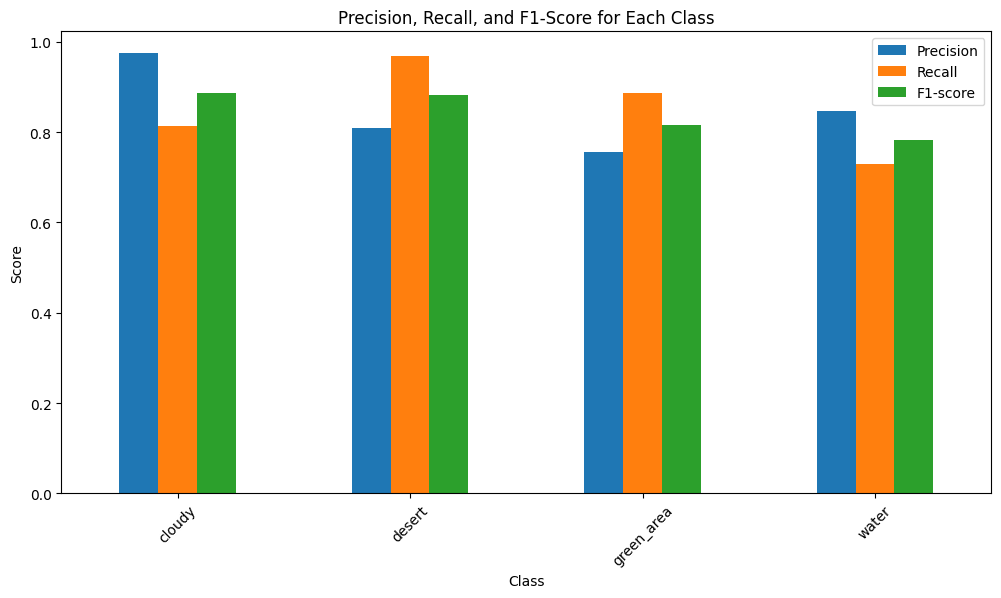

In [35]:

# Bar charts for precision, recall, and F1-score
metrics_df.plot(x='Class', kind='bar', figsize=(12, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()